# Word2Vec
here I implement word2vec with very simple example using tensorflow  
word2vec is vector representation for words with similarity

# Collect Data
we will use only 10 sentences to create word vectors

In [1]:
%pip install tensorflow

corpus = ['king is a strong man', 
          'queen is a wise woman', 
          'boy is a young man',
          'girl is a young woman',
          'prince is a young king',
          'princess is a young queen',
          'man is strong', 
          'woman is pretty',
          'prince is a boy will be king',
          'princess is a girl will be queen']

Note: you may need to restart the kernel to use updated packages.


# Remove stop words
In order for efficiency of creating word vector, we will remove commonly used words

In [2]:
def remove_stop_words(corpus):
    stop_words = ['is', 'a', 'will', 'be']
    results = []
    for text in corpus:
        tmp = text.split(' ')
        for stop_word in stop_words:
            if stop_word in tmp:
                tmp.remove(stop_word)
        results.append(" ".join(tmp))
    
    return results

In [3]:
corpus = remove_stop_words(corpus)

In [20]:
words = []
for text in corpus:
    for word in text.split(' '):
        words.append(word)

#words = set(words)

here we have word set by which we will have word vector

In [21]:
words

['king',
 'strong',
 'man',
 'queen',
 'wise',
 'woman',
 'boy',
 'young',
 'man',
 'girl',
 'young',
 'woman',
 'prince',
 'young',
 'king',
 'princess',
 'young',
 'queen',
 'man',
 'strong',
 'woman',
 'pretty',
 'prince',
 'boy',
 'king',
 'princess',
 'girl',
 'queen']

# data generation
we will generate label for each word using skip gram.  

In [22]:
word2int = {}

for i,word in enumerate(words):
    word2int[word] = i

sentences = []
for sentence in corpus:
    sentences.append(sentence.split())
    
WINDOW_SIZE = 2

data = []
for sentence in sentences:
    for idx, word in enumerate(sentence):
        for neighbor in sentence[max(idx - WINDOW_SIZE, 0) : min(idx + WINDOW_SIZE, len(sentence)) + 1] : 
            if neighbor != word:
                data.append([word, neighbor])

In [23]:
import pandas as pd
for text in corpus:
    print(text)

df = pd.DataFrame(data, columns = ['input', 'label'])

king strong man
queen wise woman
boy young man
girl young woman
prince young king
princess young queen
man strong
woman pretty
prince boy king
princess girl queen


In [24]:
df.head(10)

,input,label
0,king,strong
1,king,man
2,strong,king
3,strong,man
4,man,king
5,man,strong
6,queen,wise
7,queen,woman
8,wise,queen
9,wise,woman


In [25]:
df.shape

(52, 2)

In [26]:
word2int

{'king': 24,
 'strong': 19,
 'man': 18,
 'queen': 27,
 'wise': 4,
 'woman': 20,
 'boy': 23,
 'young': 16,
 'girl': 26,
 'prince': 22,
 'princess': 25,
 'pretty': 21}

# Define Tensorflow Graph

In [27]:
import tensorflow.compat.v1 as tf
import numpy as np

ONE_HOT_DIM = len(words)

tf.compat.v1.disable_eager_execution()



# function to convert numbers to one hot vectors
def to_one_hot_encoding(data_point_index):
    one_hot_encoding = np.zeros(ONE_HOT_DIM)
    one_hot_encoding[data_point_index] = 1
    return one_hot_encoding

X = [] # input word
Y = [] # target word

for x, y in zip(df['input'], df['label']):
    X.append(to_one_hot_encoding(word2int[ x ]))
    Y.append(to_one_hot_encoding(word2int[ y ]))

# convert them to numpy arrays
X_train = np.asarray(X)
Y_train = np.asarray(Y)

# making placeholders for X_train and Y_train
x = tf.placeholder(tf.float32, shape=(None, ONE_HOT_DIM))
y_label = tf.placeholder(tf.float32, shape=(None, ONE_HOT_DIM))

# word embedding will be 2 dimension for 2d visualization
EMBEDDING_DIM = 2 

# hidden layer: which represents word vector eventually
W1 = tf.Variable(tf.random_normal([ONE_HOT_DIM, EMBEDDING_DIM]))
b1 = tf.Variable(tf.random_normal([1])) #bias
hidden_layer = tf.add(tf.matmul(x,W1), b1)

# output layer
W2 = tf.Variable(tf.random_normal([EMBEDDING_DIM, ONE_HOT_DIM]))
b2 = tf.Variable(tf.random_normal([1]))
prediction = tf.nn.softmax(tf.add( tf.matmul(hidden_layer, W2), b2))

# loss function: cross entropy
loss = tf.reduce_mean(-tf.reduce_sum(y_label * tf.log(prediction), axis=[1]))

# training operation
train_op = tf.train.GradientDescentOptimizer(0.05).minimize(loss)

# Train

In [28]:
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init) 

iteration = 20000
for i in range(iteration):
    # input is X_train which is one hot encoded word
    # label is Y_train which is one hot encoded neighbor word
    sess.run(train_op, feed_dict={x: X_train, y_label: Y_train})
    if i % 3000 == 0:
        print('iteration '+str(i)+' loss is : ', sess.run(loss, feed_dict={x: X_train, y_label: Y_train}))

iteration 0 loss is :  6.2467933
iteration 3000 loss is :  1.8785831
iteration 6000 loss is :  1.8158193
iteration 9000 loss is :  1.7950273
iteration 12000 loss is :  1.7812837
iteration 15000 loss is :  1.770565
iteration 18000 loss is :  1.7616416


In [29]:
# Now the hidden layer (W1 + b1) is actually the word look up table
vectors = sess.run(W1 + b1)
print(vectors)

[[ 1.2799898   2.5794942 ]
 [ 2.3092406   2.8325996 ]
 [ 1.6568924   4.4072948 ]
 [ 2.4989953   5.096077  ]
 [ 5.6132154   3.0227191 ]
 [ 2.298729    1.7509481 ]
 [ 2.8577976   1.4993163 ]
 [ 1.8904525   3.104894  ]
 [ 2.814247    2.135679  ]
 [ 3.861414    0.57891226]
 [ 3.1850371   4.5080996 ]
 [ 2.896353    3.9022737 ]
 [ 3.8323243   3.2084658 ]
 [ 2.3113947   3.0328803 ]
 [ 2.7126055   3.0363524 ]
 [ 2.5189254   4.2036877 ]
 [ 0.26776385  0.97433805]
 [ 2.116088    3.208595  ]
 [ 1.9481302   7.8238363 ]
 [-1.6956604   4.945993  ]
 [ 1.5404276   0.43332863]
 [ 5.645862    2.4019592 ]
 [ 1.6620146   8.075739  ]
 [ 0.32897925  3.2447362 ]
 [ 0.54146385  3.118504  ]
 [ 4.492917    4.332857  ]
 [ 5.3955746   3.2249765 ]
 [ 4.538559    1.7582169 ]]


# word vector in table

In [30]:
w2v_df = pd.DataFrame(vectors, columns = ['x1', 'x2'])
w2v_df['word'] = words
w2v_df = w2v_df[['word', 'x1', 'x2']]
w2v_df

,word,x1,x2
0,king,1.279990,2.579494
1,strong,2.309241,2.832600
2,man,1.656892,4.407295
3,queen,2.498995,5.096077
4,wise,5.613215,3.022719
5,woman,2.298729,1.750948
6,boy,2.857798,1.499316
7,young,1.890453,3.104894
8,man,2.814247,2.135679
9,girl,3.861414,0.578912


# word vector in 2d chart

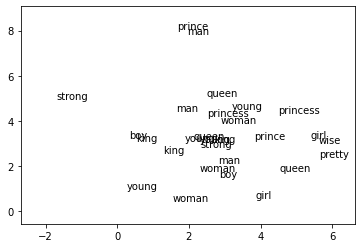

In [31]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

for word, x1, x2 in zip(w2v_df['word'], w2v_df['x1'], w2v_df['x2']):
    ax.annotate(word, (x1,x2 ))
    
PADDING = 1.0
x_axis_min = np.amin(vectors, axis=0)[0] - PADDING
y_axis_min = np.amin(vectors, axis=0)[1] - PADDING
x_axis_max = np.amax(vectors, axis=0)[0] + PADDING
y_axis_max = np.amax(vectors, axis=0)[1] + PADDING
 
plt.xlim(x_axis_min,x_axis_max)
plt.ylim(y_axis_min,y_axis_max)
plt.rcParams["figure.figsize"] = (10,10)

plt.show()